Starting audio creation and video merge for experiment: exp_001
Generating sound for action potentials at times: [0.0703 0.0784 0.0871 ... 0.8408 0.8512 0.8617]
Audio saved as: D:\OneDrive\Escritorio\101024_0002_output\exp_001_audio.wav
Moviepy - Building video D:\OneDrive\Escritorio\101024_0002_output\exp_001_video.mp4.
MoviePy - Writing audio in exp_001_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video D:\OneDrive\Escritorio\101024_0002_output\exp_001_video.mp4



MovieWriter imagemagick unavailable; using Pillow instead.  


Moviepy - Done !
Moviepy - video ready D:\OneDrive\Escritorio\101024_0002_output\exp_001_video.mp4
Video saved as: D:\OneDrive\Escritorio\101024_0002_output\exp_001_video.mp4
GIF saved as: D:\OneDrive\Escritorio\101024_0002_output\exp_001_animation.gif


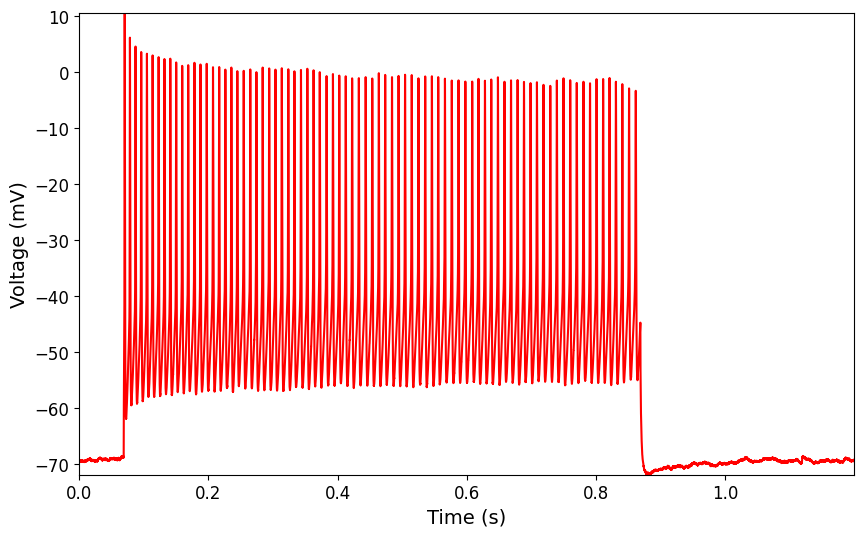

In [1]:
# Import necessary libraries
import pyabf
import numpy as np
import os
from scipy.signal import find_peaks
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
from moviepy.editor import VideoClip, AudioFileClip
import moviepy.video.fx.all as vfx
import inspect  # Import the inspect module
from matplotlib.animation import FuncAnimation

# Define a function to analyze .abf files
def analyze_abf_file(abf_file_path, selected_trace, voltage_threshold):
    # Load the .abf file
    abf = pyabf.ABF(abf_file_path)
    
    # Analyze the selected trace
    abf.setSweep(selected_trace)
    time = abf.sweepX
    voltage = abf.sweepY

    # Detect peaks using scipy
    peaks, _ = find_peaks(voltage, height=voltage_threshold, distance=int(abf.dataRate * 0.001))  # Adjust 'distance' as needed
    spike_times = time[peaks] if peaks.size > 0 else np.array([])

    return time, voltage, peaks

# Function to generate sound from action potentials
def generate_sound_for_ap(ap_times, duration, sampling_rate, base_frequency=220, amplitude=1.0, gain=1.0, tone_duration=0.1):
    print(f"Generating sound for action potentials at times: {ap_times}")
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    audio = np.zeros_like(t)
    
    for ap_time in ap_times:
        start_idx = int(ap_time * sampling_rate)
        end_idx = start_idx + int(sampling_rate * tone_duration)  # Adjust tone duration
        end_idx = min(end_idx, len(t))
        audio[start_idx:end_idx] = gain * amplitude * np.sin(2 * np.pi * base_frequency * t[:end_idx - start_idx])
    
    return audio

# Function to create audio and merge it with video
def create_audio_and_merge_with_video(time, voltage, duration_s, abf_file_path, experiment_id, peaks, gain, tone_duration, playback_speed, volume, base_frequency, trace_color):
    print(f"Starting audio creation and video merge for experiment: {experiment_id}")
    amplitude = np.iinfo(np.int16).max
    audio_fs = int(len(time) / duration_s)
    
    # Normalize ephys data to range [-1, 1]
    normalized_data = voltage / np.max(np.abs(voltage))
    
    # Scale data, reducing background noise
    scaled_data = np.int16(np.clip(normalized_data, -1, -0.06) * amplitude * gain * volume)
    
    ap_sounds = generate_sound_for_ap(peaks / audio_fs, duration_s, audio_fs, base_frequency=base_frequency, gain=gain, tone_duration=tone_duration)
    
    # Ensure both arrays have the same length
    final_audio = np.zeros_like(scaled_data)
    min_length = min(len(final_audio), len(ap_sounds))
    final_audio[:min_length] = np.int16(ap_sounds[:min_length] * amplitude * gain * volume)
    final_audio = np.int16(np.clip(final_audio, -amplitude, amplitude))

    base_filename = os.path.splitext(os.path.basename(abf_file_path))[0]
    output_folder = os.path.join(os.path.dirname(abf_file_path), f"{base_filename}_output")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    audio_output_path = os.path.join(output_folder, f"{experiment_id}_audio.wav")
    write(audio_output_path, audio_fs, final_audio)

    print(f"Audio saved as: {audio_output_path}")

    # Create a video visualization of the action potential
    def make_frame(t):
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.set_xlim(time[0], time[-1])  # Show entire sweep
        ax.set_ylim(min(voltage), max(voltage))  # Keep voltage axis fixed
        ax.set_xlabel('Time (s)', fontsize=14)
        ax.set_ylabel('Voltage (mV)', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        # Draw only up to the current time t
        current_time_mask = time <= t
        ax.plot(time[current_time_mask], voltage[current_time_mask], color=trace_color)
        
        # Save frame as an image buffer
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return image

    video_output_path = os.path.join(output_folder, f"{experiment_id}_video.mp4")
    video = VideoClip(make_frame, duration=duration_s)
    audio = AudioFileClip(audio_output_path)
    video = video.set_audio(audio)
    
    # Adjust playback speed using vfx.speedx
    video = video.fx(vfx.speedx, factor=playback_speed)
    
    video.write_videofile(video_output_path, fps=24, codec='libx264', bitrate='8000k')
    print(f"Video saved as: {video_output_path}")

    # Create and save an animated GIF
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.set_xlim(time[0], time[-1])
    ax.set_ylim(min(voltage), max(voltage))
    ax.set_xlabel('Time (s)', fontsize=14)
    ax.set_ylabel('Voltage (mV)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    line, = ax.plot([], [], color=trace_color)

    def update(frame):
        current_time_mask = time <= frame
        line.set_data(time[current_time_mask], voltage[current_time_mask])
        return line,

    ani = FuncAnimation(fig, update, frames=np.linspace(time[0], time[-1], int(duration_s * 24)), blit=True)
    gif_output_path = os.path.join(output_folder, f"{experiment_id}_animation.gif")
    ani.save(gif_output_path, writer='imagemagick', fps=24)
    print(f"GIF saved as: {gif_output_path}")

# Input parameters

abf_file_path = r"D:\OneDrive\Escritorio\101024_0002.abf" # load here your .ABF file path r"......"
selected_trace = 9  # Specific trace from .abf file to analyze
voltage_threshold = -20  # Voltage threshold to detect peaks

# Analyze .abf file and generate results
time, voltage, peaks = analyze_abf_file(abf_file_path, selected_trace, voltage_threshold)

# If action potentials are detected, generate audio and video
if peaks is not None:
    experiment_id = "exp_001"
    duration_s = time[-1] - time[0]  # Full sweep duration
    gain = 1  # Adjust gain as needed
    tone_duration = 0.1  # Tone duration in seconds
    playback_speed = 0.4  # Adjust playback speed (1.0 = normal, 0.5 = half speed, etc.)
    volume = 1  # Adjust volume (1.0 = max)
    base_frequency = 20  # Base tone frequency
    trace_color = 'red'  # Trace color
    create_audio_and_merge_with_video(time, voltage, duration_s, abf_file_path, experiment_id, peaks, gain, tone_duration, playback_speed, volume, base_frequency, trace_color)
